## Contents

* Load Data
* Shot-In-The-Dark Featurization 
* Model: CRF
* Selectional Preference Strength (SPS)
* Selectional Association Strength (SAS)

## I. Load Data

### A. Load Raw Data

In [1]:
import pickle

In [2]:
path = "/Users/jacobsw/Desktop/WORK/OJO/NER_PRESENTATION/DATA/atis.pkl"

In [44]:
def load_atis(path):
    
    with open(path, 'rb') as f:
        train, valid, test, dicts = pickle.load(f)
    
    train = (train[0],train[2]) # 0: encoded words; 1: encoded labels.
    valid = (valid[0],valid[2])
    test = (test[0],test[2])

    return {'train':train, 'valid':valid, 'test':test, 'dicts':dicts}

In [45]:
data = load_atis(path)

In [46]:
train, valid, test, dicts = data['train'], data['valid'], data['test'], data['dicts']
i2w = {i:w for w,i in dicts['words2idx'].iteritems()}
i2l = {i:l for l,i in dicts['labels2idx'].iteritems()}

In [47]:
X_train = [map(i2w.get, encoded_sent) for encoded_sent in train[0]]
X_test = [map(i2w.get, encoded_sent) for encoded_sent in test[0]]
Y_train = [map(i2l.get, encoded_labels) for encoded_labels in train[1]]
Y_test = [map(i2l.get, encoded_sent) for encoded_sent in test[1]]

### B. Data Augmentation

In [50]:
from spacy.en import English

In [7]:
parser = English()

def extract_info(sent): 
    
    if type(sent)==list: sent = ' '.join(sent)
    parsed = parser(unicode(sent))# if type(sent)==str else parser(unicode(sent))
    pos = [token.pos_ for token in parsed]
    ner = ['none' if token.ent_type_=='' else token.ent_type_ for token in parsed]
    dep_rel = [token.dep_ for token in parsed]
    dep_head = [token.head.orth_ for token in parsed]
    
    return (sent.split(), pos, ner, dep_rel, dep_head)


In [51]:
X_train_augmented = [extract_info(sent) for sent in X_train]
X_test_augmented = [extract_info(sent) for sent in X_test]

In [52]:
train = [(x_augmented,y) for x_augmented,y in zip(X_train_augmented,Y_train)]
test = [(x_augmented,y) for x_augmented,y in zip(X_test_augmented,Y_test)]

## II. Shot-In-The-Dark Featurization

In [53]:
from pyparsing import StringEnd, oneOf, FollowedBy, Optional, ZeroOrMore, SkipTo

In [54]:
prefix = ['anti','de','dis','en','em','fore','in','im','il','ir',
          'inter','mid','mis','non','over','pre','re','semi','sub',
          'super','trans','un','under']
suffix = ['able','ible','al','ial','ed','en','er','est','ful','ic',
          'ing','ion','tion','ation','ition','ity','ty','ive','ative',
          'itive','less','ly','ment','ness','ous','eous','ious','s',
          'es','y','ism']

In [55]:
class FeatureExtractor: # for SPS,SAS
    
    def __init__(self, prefix=[], suffix=[]): # lists of pfx/sfx.
        self.prefix = prefix
        self.suffix = suffix
        end_of_string = StringEnd()
        pfx_pyp_regex = oneOf(' '.join(prefix))
        sfx_pyp_regex = oneOf(' '.join(suffix)) + FollowedBy(end_of_string)
        self.template = (ZeroOrMore(pfx_pyp_regex)('prefix') +
                         SkipTo(sfx_pyp_regex | end_of_string)('root') + 
                         Optional(sfx_pyp_regex)('suffix'))              
        self.afx = lambda word: self.template.parseString(word)
        self.feat_set = {'pfx': lambda w_idx,datum: self.afx(datum[0][w_idx]).prefix[0] \
                                     if self.afx(datum[0][w_idx]).prefix!='' else 'no_pfx',
                         'sfx': lambda w_idx,datum: self.afx(datum[0][w_idx]).suffix[0] \
                                     if self.afx(datum[0][w_idx]).suffix!='' else 'no_sfx',
                         'root': lambda w_idx,datum: self.afx(datum[0][w_idx]).root,
                         'word': lambda w_idx,datum: datum[0][w_idx],
                         'pos': lambda w_idx,datum: datum[1][w_idx],
                         'ner': lambda w_idx,datum: datum[2][w_idx],
                         'dep_rel': lambda w_idx,datum: datum[3][w_idx],
                         'dep_head': lambda w_idx,datum: datum[4][w_idx]} 
            # datum: (words, pos, ner, dep_rel, dep_head)
        
    def get_feature(self, w_idx, (datum,labels), feature='pfx'):
        return (labels[w_idx], self.feat_set[feature](w_idx, datum))


In [56]:
class Featurize: # for CRF
    
    def __init__(self, prefix=[], suffix=[]): # lists of pfx/sfx.
        self.prefix = prefix
        self.suffix = suffix
        end_of_string = StringEnd()
        pfx_pyp_regex = oneOf(' '.join(prefix))
        sfx_pyp_regex = oneOf(' '.join(suffix)) + FollowedBy(end_of_string)
        self.template = (ZeroOrMore(pfx_pyp_regex)('prefix') +
                         SkipTo(sfx_pyp_regex | end_of_string)('root') + 
                         Optional(sfx_pyp_regex)('suffix'))              
        self.afx = lambda word: self.template.parseString(word)
        self.feat_set = {'pfx': lambda w_idx,datum: self.afx(datum[0][w_idx]).prefix[0] \
                                     if self.afx(datum[0][w_idx]).prefix!='' else 'no_pfx',
                         'sfx': lambda w_idx,datum: self.afx(datum[0][w_idx]).suffix[0] \
                                     if self.afx(datum[0][w_idx]).suffix!='' else 'no_sfx',
                         'root': lambda w_idx,datum: self.afx(datum[0][w_idx]).root,
                         'word': lambda w_idx,datum: datum[0][w_idx],
                         'pos': lambda w_idx,datum: datum[1][w_idx],
                         'ner': lambda w_idx,datum: datum[2][w_idx],
                         'dep_rel': lambda w_idx,datum: datum[3][w_idx],
                         'dep_head': lambda w_idx,datum: datum[4][w_idx]} 
            # datum: (words, pos, ner, dep_rel, dep_head)
        
    def word_featurize(self, datum, i, 
                       FEATURES=['pfx','sfx','root','word','pos','ner','dep_rel','dep_head']): 
        # datum: (sent, pos, ner, dep_rel, dep_head).
        # i: index of the token processed. 
        features = []
        for feat in FEATURES:
            features.append(feat+'='+str(self.feat_set[feat](i,datum)))
        if i > 0:
            for feat in FEATURES:
                features.append('-1'+feat+'='+str(self.feat_set[feat](i-1,datum)))
                if i > 1:
                    features.append('-2'+feat+'='+str(self.feat_set[feat](i-2,datum)))
        else: features.append('BOS')
        if i < len(datum[0])-1:
            for feat in FEATURES:
                features.append('+1'+feat+'='+str(str(self.feat_set[feat](i+1,datum))))
                if i < len(datum[0])-2:
                    features.append('+2'+feat+'='+str(str(self.feat_set[feat](i+2,datum))))
        else: features.append('EOS')    
        return features
        
    def sent_featurize(self, datum, FEATURES=['pfx','sfx','root','word','pos','ner','dep_rel','dep_head']):
        # datum: (sent, pos, ner, dep_rel, dep_head).   
        return [self.word_featurize(datum, i, FEATURES) for i in xrange(len(datum[0]))] 

## III. Model: CRF

In [57]:
from itertools import chain
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
import sklearn
import pycrfsuite
import time, random
from sklearn.metrics import accuracy_score

In [58]:
class CRF:
    
    def __init__(self, train, test,
                 featurizer=Featurize(prefix, suffix),
                 FEATURES=['pfx','sfx','root','word','pos','ner','dep_rel','dep_head']):
        self.FEATURES = FEATURES
        self.X_train = [featurizer.sent_featurize(datum[0],FEATURES) for datum in train]
        self.Y_train = [datum[1] for datum in train]
        self.X_test = [featurizer.sent_featurize(datum[0],FEATURES) for datum in test]
        self.Y_test = [datum[1] for datum in test]
    
    def train(self, config={'c1': 1.0, 
                            'c2': 1e-3, 
                            'max_iterations': 100,
                            'feature.possible_transitions':True}):
        crf = pycrfsuite.Trainer(verbose=0)               
        for x,y in zip(self.X_train,self.Y_train):
            crf.append(x,y)
        crf.set_params(config)
        tagger_name=time.ctime()+'crf.crfsuite' # avoid repetition
        crf.train(tagger_name)
        self.tagger = pycrfsuite.Tagger()
        self.tagger.open(tagger_name)
        
        y_true = self.Y_test
        y_pred = [self.tagger.tag(sent) for sent in self.X_test]
        y_true_merged = list(chain.from_iterable(y_true))
        y_pred_merged = list(chain.from_iterable(y_pred)) 
        accuracy = accuracy_score(y_true_merged,y_pred_merged)
        
        return accuracy
        

## IV. Selectional Preference Strength

### A. SPS Facilities

* **Selectional Preference Strength (SPS)**: The extent to which the probability of observing a feature $ft$ increases (from its marginal probability distribution on a dataset) on conditioning $ft$ on a particular label $l$.

* **SPS**: $SPS(l) = D_{KL}(P(ft|l)||P(ft)) = \sum_{i}P(ft_i|l)\cdot log\frac{P(ft_i|l)}{P(ft_i)}$.

In [59]:
import numpy as np
from __future__ import division

In [60]:
def selectional_strength(data, feature):
    
    ft_ex = FeatureExtractor(prefix, suffix)
    
    label_feat_pairs = []
    for (datum,labels) in data:
        for w_idx in xrange(len(datum[0])):
            label_feat_pairs.append(ft_ex.get_feature(w_idx,(datum,labels),feature=feature))
    
    feat_set = list({feat for label,feat in label_feat_pairs})
    label_set = list({label for label,feat in label_feat_pairs})
    
    f2i = {f:i for i,f in enumerate(feat_set)}
    l2i = {l:i for i,l in enumerate(label_set)}
    
    label_feat_matrix = np.zeros((len(label_set),len(feat_set)))
    for label,feat in label_feat_pairs:
        label_feat_matrix[l2i[label]][f2i[feat]] += 1
    
    total_freq = label_feat_matrix.sum()
    
    log = lambda x: np.log(x) if x!=0 else np.log(1e-20)
    div = lambda num,denom: 0. if denom==0. else num/denom
    
    def pr_feat(feat):
        return label_feat_matrix[:,f2i[feat]].sum() / total_freq

    def pr_feat_given_label(feat, label):
        return label_feat_matrix[l2i[label]][f2i[feat]] / \
                label_feat_matrix[l2i[label],:].sum()

    def sps_feat(label):
        return sum(pr_feat_given_label(feat,label)*log(div(pr_feat_given_label(feat,label),pr_feat(feat)))
                   for feat in feat_set)
    
    return sum(sps_feat(label) for label in label_set)
    

In [61]:
features = ['pfx','sfx','root','word','pos','ner','dep_rel','dep_head']

In [62]:
%%time
sps_list = []
for feature in features:
    sps = selectional_strength(train, feature)
    sps_list.append(sps)
    print "Selectional Preference Strength of %s: %.6f" % (feature, sps)

Selectional Preference Strength of pfx: 17.780486
Selectional Preference Strength of sfx: 133.128422
Selectional Preference Strength of root: 639.749198
Selectional Preference Strength of word: 657.157284
Selectional Preference Strength of pos: 168.285976
Selectional Preference Strength of ner: 89.761791
Selectional Preference Strength of dep_rel: 208.981067
Selectional Preference Strength of dep_head: 419.078054
CPU times: user 23.6 s, sys: 152 ms, total: 23.7 s
Wall time: 23.7 s


### B. Evaluation

In [66]:
from scipy.stats.stats import pearsonr
import matplotlib.pyplot as plt
%matplotlib inline

In [64]:
%%time
accuracies = []
for feature in features:
    crf = CRF(train, test, FEATURES=[feature])
    accuracy = crf.train()
    accuracies.append(accuracy)
    print "Accuracy with only %s: %.6f" % (feature, accuracy*100)

Accuracy with only pfx: 62.230920
Accuracy with only sfx: 72.048271
Accuracy with only root: 96.031746
Accuracy with only word: 95.988258
Accuracy with only pos: 76.407915
Accuracy with only ner: 64.285714
Accuracy with only dep_rel: 77.310285
Accuracy with only dep_head: 83.648619
CPU times: user 23min 14s, sys: 7.09 s, total: 23min 21s
Wall time: 23min 29s


In [68]:
print "Pearson Correlation: %.6f | p-value: %.6f" % pearsonr(sps_list, accuracies)

Pearson Correlation: 0.976704 | p-value: 0.000031


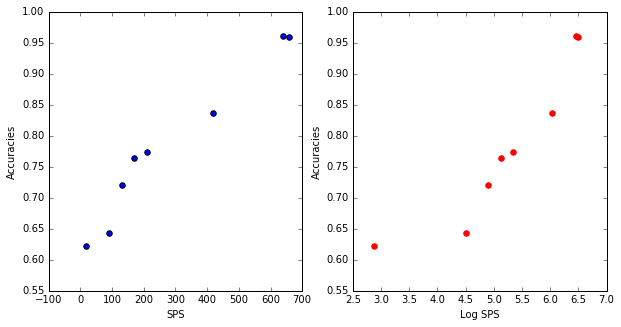

In [70]:
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(121)
ax.scatter(sps_list, accuracies, s=30)
ax.set_xlabel('SPS')
ax.set_ylabel('Accuracies')
ax = plt.subplot(122)
ax.scatter(np.log(sps_list), accuracies, s=30, color='red')
ax.set_xlabel('Log SPS')
ax.set_ylabel('Accuracies')
plt.show()

## V. Selectional Association Strength

* **Selectional Association Strength (SAS)**: The contribution of a feature value $ft_i$ to the overall $SPS$ of a label $l$ with respect to $ft$.
* **SAS**: * $SAS(ft_i,l) = \frac{P(ft_i|l)\cdot log\frac{P(ft_i|l)}{P(ft_i)}}{SPS(l)}$.

### A. SAS Facilities

In [74]:
import numpy as np

In [71]:
log = lambda x: np.log(x) if x>0 else np.log(1e-20)
div = lambda x,y: x/y if y!=0 else 0

In [77]:
w2i = dicts['words2idx']
l2i = dicts['labels2idx']
word_vocab = w2i.keys()
label_vocab = l2i.keys()

In [75]:
def build_w2l_matrix(pos):
    m = np.zeros((len(word_vocab),len(label_vocab)))
    for X,Y in zip(X_train,Y_train):
        for i in xrange(abs(pos),min(len(Y),len(Y)-pos)):
            m[w2i[X[i+pos]]][l2i[Y[i]]] += 1
    return m

def resnik_association_matrix(w2l):
    
    total_count = w2l.sum()
    p_w = lambda w: div(w2l[w2i[w],:].sum(), total_count)
    p_w_given_l = lambda w,l: div(w2l[w2i[w]][l2i[l]], w2l[:,l2i[l]].sum())
    sps_w_l = lambda w,l: p_w_given_l(w,l)*log(div(p_w_given_l(w,l),p_w(w)))
    sps_l = lambda l: sum(p_w_given_l(w,l)*log(div(p_w_given_l(w,l),p_w(w))) 
                          for w in word_vocab)
    
    asso_w_l = np.zeros((len(word_vocab),len(label_vocab)))
    for l in label_vocab:
        s_l = sps_l(l)
        for w in word_vocab:
            asso_w_l[w2i[w]][l2i[l]] = div(sps_w_l(w,l),s_l)
    
    return asso_w_l

def top_k(asso, l, k=5):
    
    l_vec = asso[:,l2i[l]]
    k_ws = np.argsort(l_vec)[::-1][:k]
    
    return zip(map(i2w.get, k_ws),[l_vec[w_idx] for w_idx in k_ws])

In [78]:
w2l_ms = {'neg2':build_w2l_matrix(pos=-2),
          'neg1':build_w2l_matrix(pos=-1),
          'zero':build_w2l_matrix(pos=0),
          'pos1':build_w2l_matrix(pos=1),
          'pos2':build_w2l_matrix(pos=2)}

In [79]:
asso_ms = {'neg2':resnik_association_matrix(w2l_ms['neg2']),
           'neg1':resnik_association_matrix(w2l_ms['neg1']),
           'zero':resnik_association_matrix(w2l_ms['zero']),
           'pos1':resnik_association_matrix(w2l_ms['pos1']),
           'pos2':resnik_association_matrix(w2l_ms['pos2'])}

In [81]:
l1 = 'B-fromloc.city_name'
l2 = 'B-toloc.city_name'

In [82]:
top_k(asso_ms['neg1'], l1)

[('from', 0.91907842123589178),
 ('between', 0.071307412020743574),
 ('leaving', 0.021747763665529767),
 ('leave', 0.010534667010072322),
 ('leaves', 0.00080508222757163454)]

In [83]:
top_k(asso_ms['neg1'], l2)

[('to', 0.92025153953489625),
 ('and', 0.051358698459713206),
 ('in', 0.019955171600037791),
 ('downtown', 0.0059494972721757028),
 ('into', 0.0052958856826928287)]